# Clasificación de imágenes usando OpenCV y CNN (Convolutional Neural Network)

## Cargar y explorar datos

Primeramente cargamos los datos desde un dataset real que provee keras. Este dataset contiene **imágenes**, representadas de ahora en adelante con una *x* (`x_train`, `x_test`) y sus respectivas **etiquetas**, representadas con una *y* (`y_train`, `y_test`). Note que los 4 resultados que brinda `load_data()` son de tipo ndarray, que es del paquete numpy.

In [1]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(type(x_train), type(y_train), type(x_test), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


El primer valor de los 4 arrays son las filas. Por lo tanto, las imágenes y etiquetas de entrenamiento tienen 50000 filas, y las imágenes y etiquetas de prueba tienen 10000. Todas las etiquetas tienen una sola columna indicando la etiqueta a la que pertenece su análogo en *x*. Sin embargo, lo interesante son las dimensiones de las imágenes. Cada fila de *x* tiene una imagen de 32x32 con 3 colores (rojo, verde, azul).

In [2]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 32, 32, 3)
y_test shape:  (10000, 1)


## Definición de etiquetas

Este dataset en particular contiene las siguientes definidas en `etiquetas_dataset`. Este array lo usaremos más adelante para determinar si nuestro modelo pudo determinar de manera correcta la predicción.

In [3]:
etiquetas_dataset = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

## Explorar una imagen de entrenamiento

Exploramos y desplegamos una imagen al azar para entender el contenido de una fila.

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [253 253 253]
  [253 253 253]
  ...
  [253 253 253]
  [253 253 253]
  [255 255 255]]

 [[255 255 255]
  [253 253 253]
  [254 254 254]
  ...
  [254 254 254]
  [253 253 253]
  [255 255 255]]

 ...

 [[255 255 255]
  [253 253 253]
  [254 254 254]
  ...
  [254 254 255]
  [253 253 254]
  [255 255 255]]

 [[255 255 255]
  [253 253 253]
  [254 254 254]
  ...
  [254 254 254]
  [253 253 254]
  [255 255 255]]

 [[255 255 255]
  [253 253 253]
  [254 254 254]
  ...
  [254 254 254]
  [253 253 253]
  [255 255 255]]]


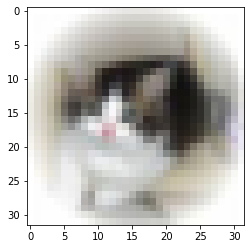

In [4]:
import matplotlib.pyplot as plt

ejemplo_index = 203
x_train[ejemplo_index]

print(x_train[ejemplo_index])
img = plt.imshow(x_train[ejemplo_index])

## Explorar una etiqueta de entrenamiento

Es importante tomar en cuenta que las etiquetas están representadas por números. Por lo tanto, siempre tendremos que tomar en cuenta el array definido en `etiquetas_dataset` para identificar la etiqueta respectiva. Esto aplicando tanto para el entrenamiento, la prueba, como la predicción.

In [5]:
print("Valor 'Y': ", y_train[ejemplo_index])
print("Palabra 'Y': ", etiquetas_dataset[y_train[ejemplo_index][0]])

Valor 'Y':  [3]
Palabra 'Y':  cat


## Covertir las etiquetas en números

Para realizar el entrenamiento, el modelo en **y** necesita que cada fila sea un array de 10 elementos (la cantidad de etiquetas). Por lo tanto, ocupamos convetir esas etiquetas a números únicos para cada etiqueta.

In [6]:
from keras.utils import to_categorical

y_train_numeros = to_categorical(y_train)
y_test_numeros = to_categorical(y_test)

print("'Y' valor ententero: ", y_train_numeros[ejemplo_index])

'Y' valor ententero:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Normalizar las imágenes

La otra preparación que necesitamos hacer es normalizar las imágenes *x*. Por lo que los pixels tendrán valores entre 0 y 1.

In [7]:
x_train = x_train / 255
x_test = x_test / 255
x_train[ejemplo_index]

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99215686, 0.99215686, 0.99215686],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99607843, 0

## Arquitectura para el modelo
Definimos una arquitectura para el modelo.

- **Primera capa - Conv2D:** Conv2D representa una capa convolucional de dos dimensiones. `32` es el número de filtros requeridos y `(5, 5)` es el tamaño del filtro. El `input_shape` son las dimensiones de cada imagen (32x32 y los 3 colores RGB). La salida de esta capa son *feature maps*, los cuales son mapas con características (*features*) de la imagen.
- **Capa pooling:** Es una capa para reducir dimensionalidad de cada *feature map* pero manteniendo información relevante. Esto ayuda reduciendo la complejidad computación de la red neuronal.
- **Capa flatten**: Se usa para aplanar. Convierte los *feature map* a una sola dimensión.
- **Capa dropout**: Se usa para prevenir el sobreajuste. Es decir, prevenir el sobreentrenamiento.
- **Funciones de activación:**
    - **ReLu**: Reemplaza todos los pixeles negativos en los *features maps*
    - **Softmax**: Se usa para normalizar.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

def construir_modelo():
    modelo = Sequential()
    
    # Primera capa
    modelo.add(Conv2D(32, (5, 5), activation="relu", input_shape=(32, 32, 3)))

    # Capa pooling
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    # Capa Conv2D
    modelo.add(Conv2D(32, (5, 5), activation="relu"))

    # Capa pooling
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    # Capa flatten
    modelo.add(Flatten())

    # Capa ReLu - 1000 neuronas
    modelo.add(Dense(1000, activation="relu"))

    # Dropout al 50%
    modelo.add(Dropout(0.5))

    # Capa ReLu - 500 neuronas
    modelo.add(Dense(500, activation="relu"))

    # Dropout al 50%
    modelo.add(Dropout(0.5))

    # Capa ReLu - 250 neuronas
    modelo.add(Dense(250, activation="relu"))

    # Capa Softmax - 10 neuronas
    modelo.add(Dense(10, activation="softmax"))
    return modelo

modelo = construir_modelo()
print(modelo.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 1000)              8

## Compilar el modelo

Luego de definir la arquitectura, obtenemos el modelo y lo compilamos para empezar a entrenar y predecir. `categorical_crossentropy` compara la distribución de las predicciones con las actuales distribuciones. Usamos el optimizador `adam` por su rendimiento. Además, definimos que queremos visualizar la precisión en las métricas.

In [9]:
modelo.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## Realizamos el entrenamiento

Para realizar el entrenamiento, pasamos como parámetro las imágenes de entrenamiento `x_train`, las etiquetas de entrenamiento en números `y_train_enteros`, y una configuración predeterminada.  
El `batch_size` se refiere a la cantidad de elementos del conjunto de entrenamiento que se utilizan para entrenar la red en cada iteración.  
`epochs` es la cantidad de veces que se pasan **todos** los datos por la red. 

In [10]:
entrenamiento = modelo.fit(x_train, y_train_numeros, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
157/157 [==============================] - 14s 86ms/step - loss: 1.8018 - accuracy: 0.3244 - val_loss: 1.5640 - val_accuracy: 0.4118
Epoch 2/20
157/157 [==============================] - 14s 88ms/step - loss: 1.4420 - accuracy: 0.4721 - val_loss: 1.3540 - val_accuracy: 0.5149
Epoch 3/20
157/157 [==============================] - 13s 85ms/step - loss: 1.3089 - accuracy: 0.5264 - val_loss: 1.2751 - val_accuracy: 0.5381
Epoch 4/20
157/157 [==============================] - 14s 89ms/step - loss: 1.2028 - accuracy: 0.5698 - val_loss: 1.2792 - val_accuracy: 0.5526
Epoch 5/20
157/157 [==============================] - 14s 92ms/step - loss: 1.1352 - accuracy: 0.5965 - val_loss: 1.0864 - val_accuracy: 0.6192
Epoch 6/20
157/157 [==============================] - 13s 85ms/step - loss: 1.0537 - accuracy: 0.6259 - val_loss: 1.0643 - val_accuracy: 0.6212
Epoch 7/20
157/157 [==============================] - 13s 83ms/step - loss: 0.9856 - accuracy: 0.6491 - val_loss: 1.0694 - val_accuracy:

## Evaluación del modelo

Realizamos una evaluación del modelo llamando al método `evaluate`. Note que ocupamos pasar las imágenes de prueba `x_test` y las etiquetas de prueba `y_test_enteros`. En este caso en particular, la precisión ronda alrededor del 70%.

313/313 [==============================] - 1s 4ms/step - loss: 0.9531 - accuracy: 0.6943


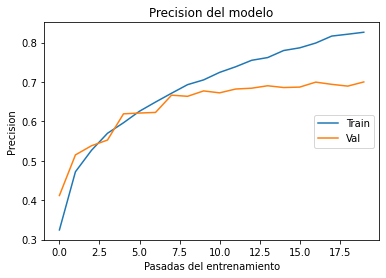

In [14]:
modelo.evaluate(x_test, y_test_numeros)[1]

plt.plot(entrenamiento.history["accuracy"])
plt.plot(entrenamiento.history["val_accuracy"])
plt.title("Precision del modelo")
plt.ylabel("Precision")
plt.xlabel("Pasadas del entrenamiento")
plt.legend(["Train", "Val"], loc="right")

## Ejemplo real

### Predicción

Para realizar una predicción con una imagen real, necesitamos primeramente cargar la imagen y transformarla obligatoriamente a 32x32. Recuerde que definimos esas dimensiones a la hora de crear y entrenar el modelo. Luego, usamos el método `modelo.predict(np.array([imagen_pequenna]))`. `predict` recibe un array de numpy con la imagen transformada previamente. La predicción retorna un array con un solo elemento también de tipo array, por lo que por comodidad devolvemos el array interno. Dicho "array interno" tiene 10 elementos. Cada elemento representa el nivel de confianza de la predicción para cada etiqueta respectivamente en `etiquetas_dataset`.

In [15]:
import cv2
import numpy as np

def obtener_prediccion(imagen):
    # Cargar imagen y transformarla a 32x32
    nueva_imagen = cv2.imread(imagen)
    nueva_imagen = cv2.cvtColor(nueva_imagen, cv2.COLOR_BGR2RGB)
    imagen_pequenna = cv2.resize(nueva_imagen, (32,32))

    # Realizar prediccion
    prediccion_array = modelo.predict(np.array([imagen_pequenna]))
    return prediccion_array[0]

prediccion_perrito = obtener_prediccion("perrito.jpg")
print(prediccion_perrito)

1/1 [==============================] - 0s 12ms/step
[3.2472217e-06 5.8791347e-06 5.1882939e-04 1.9473936e-02 6.9196307e-05
 9.7942799e-01 2.2907012e-04 2.3400084e-04 2.6548482e-06 3.5135105e-05]


### Desplegar resultados de la predicción

Se define un array `etiquetas_predicciones` de 0 a 9 que representan las etiquetas definidas previamente. Luego, de mayor a menor y tomando en cuenta `prediccion_array`, se ordena `etiquetas_predicciones`. Con este procedimiento podemos obtener las etiquetas con mejor precisión.

In [16]:
def imprimir_5_mejores_predicciones(prediccion):
    etiquetas_predicciones = [0,1,2,3,4,5,6,7,8,9]

    # Ordenar el array manualmente de acuerdo a prediccion_array de mayor a menos
    for i in range(10):
        for j in range(10):
            if prediccion[etiquetas_predicciones[i]] > prediccion[etiquetas_predicciones[j]]:
                temp = etiquetas_predicciones[i]
                etiquetas_predicciones[i] = etiquetas_predicciones[j]
                etiquetas_predicciones[j] = temp

    print(etiquetas_predicciones)
    for i in range(5):
        print(etiquetas_dataset[etiquetas_predicciones[i]])
        
imprimir_5_mejores_predicciones(prediccion_perrito)

[5, 3, 2, 7, 6, 4, 9, 1, 0, 8]
dog
cat
bird
horse
frog
